In [38]:
import arbitragelab.optimal_mean_reversion as omr
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [39]:
# Training data from 2022-01-01 to 2020-12-31
data1 =  yf.download("GLD SIL", start="2022-01-01", end="2023-12-31")

# Testing data from 2021-01-01 to 2023-06-30
data2 =  yf.download("GLD SIL", start="2024-01-01", end="2024-05-30")

# Retraining and validation data from 2023-07-01 to 2024-10-10
data3 =  yf.download("GLD SIL", start="2024-06-01", end="2024-10-10")

# to log prices
data1["Close"]["GLD"] = np.log(data1["Close"]["GLD"])
data1["Close"]["SIL"] = np.log(data1["Close"]["SIL"])

data2["Close"]["GLD"] = np.log(data2["Close"]["GLD"])
data2["Close"]["SIL"] = np.log(data2["Close"]["SIL"])

data3["Close"]["GLD"] = np.log(data3["Close"]["GLD"])
data3["Close"]["SIL"] = np.log(data3["Close"]["SIL"])

data_train_dataframe = data1["Close"][["GLD", "SIL"]]
data_test_and_retrain = data2["Close"][["GLD", "SIL"]]
data_test_the_retrained = data3["Close"][["GLD", "SIL"]]
data_train_dataframe.shape

/var/folders/lg/z6wm11r5617_11hqzqgtr_vw0000gn/T/ipykernel_3161/4117402646.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data1 =  yf.download("GLD SIL", start="2022-01-01", end="2023-12-31")
[*********************100%***********************]  2 of 2 completed
/var/folders/lg/z6wm11r5617_11hqzqgtr_vw0000gn/T/ipykernel_3161/4117402646.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data2 =  yf.download("GLD SIL", start="2024-01-01", end="2024-05-30")
[*********************100%***********************]  2 of 2 completed
/var/folders/lg/z6wm11r5617_11hqzqgtr_vw0000gn/T/ipykernel_3161/4117402646.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data3 =  yf.download("GLD SIL", start="2024-06-01", end="2024-10-10")
[*********************100%***********************]  2 of 2 completed
/var/folders/lg/z6wm11r5617_11hqzqgtr_vw0000gn/T/ipykernel_3161/4117402646.py:11: SettingWithCopyWar

(501, 2)

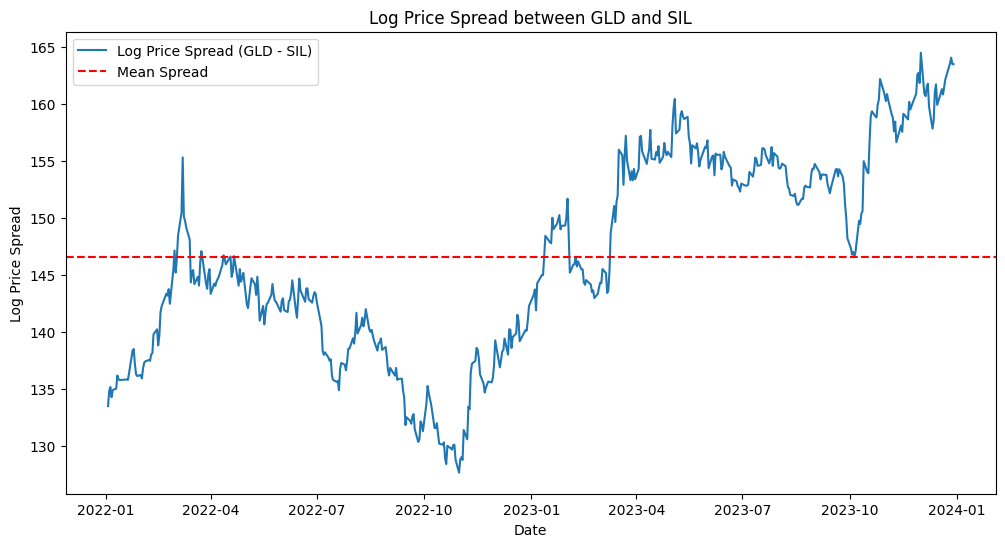

In [40]:
spread = data_train_dataframe["GLD"] - data_train_dataframe["SIL"]
plt.figure(figsize=(12, 6))
plt.plot(spread, label='Log Price Spread (GLD - SIL)')
plt.axhline(spread.mean(), color='red', linestyle='--', label='Mean Spread')
plt.title('Log Price Spread between GLD and SIL')
plt.xlabel('Date')
plt.ylabel('Log Price Spread')
plt.legend()
plt.show()

In [41]:
print(data_train_dataframe.head())

Ticker             GLD        SIL
Date                             
2022-01-03  168.330002  34.833889
2022-01-04  169.570007  34.727570
2022-01-05  169.059998  33.886688
2022-01-06  166.990005  32.707512
2022-01-07  167.750000  32.842831


In [42]:
correlation = data_test_the_retrained.corr()
print(correlation)

Ticker      GLD      SIL
Ticker                  
GLD     1.00000  0.60275
SIL     0.60275  1.00000


In [43]:
# Set up a class object
example = omr.OrnsteinUhlenbeck()

# model fit
example.fit(data_train_dataframe, data_frequency="D", discount_rate=[0.05, 0.05],
            transaction_cost=[0.02, 0.02], stop_loss=0.2)

# check fitness
example.check_fit()

,Theta,Mu,Sigma,Max log-likelihood
empirical,0.803165,1.842383,0.101973,3.632474
simulated,0.809341,3.900691,0.100529,3.581460


In [44]:
# Step 2: optimal levels
b = example.optimal_liquidation_level()
d = example.optimal_entry_level()
b_L = example.optimal_liquidation_level_stop_loss()
interval_L = example.optimal_entry_interval_stop_loss()

print("b*=",np.round(b, 4),"\nd*=",np.round(d, 4),"\nb_L*=",np.round(b_L, 4),"\n[a_L*,d_L*]=",np.round(interval_L, 4))

b*= 0.8413 
d*= 0.6778 
b_L*= 0.8413 
[a_L*,d_L*]= [0.2227 0.6778]


In [45]:
# Step 3: set stop-loss as None
example.L = None
example.description()


training period              [2022-01-03 00:00:00, 2023-12-29 00:00:00]
long-term mean                                                 0.803165
speed of reversion                                             1.842383
volatility                                                     0.101973
fitting error                                                  0.010957
discount rates                                             [0.05, 0.05]
transaction costs                                          [0.02, 0.02]
stop-loss level                                                    None
beta                                                           0.364273
optimal entry level                                            0.677798
optimal liquidation level                                      0.841348
dtype: object

In [46]:
# previously we use the use threshold at which you decide that the process has deviated far enough from the mean
# now use z-score
volatility = example.description()['volatility']
# Calculate deviation from mean in terms of volatility (Z-score)
long_term_mean = example.theta  # The long-term mean

# Optimal entry level deviation as a Z-score
optimal_entry_level = example.optimal_entry_level()
optimal_liquidation_level = example.optimal_liquidation_level()

optimal_entry_z = (optimal_entry_level - long_term_mean) / volatility
optimal_liquidation_z = (optimal_liquidation_level - long_term_mean) / volatility

print(f"Optimal Entry Level: {optimal_entry_z:.2f} standard deviations from the mean")
print(f"Optimal Liquidation Level: {optimal_liquidation_z:.2f} standard deviations from the mean")

Optimal Entry Level: -1.23 standard deviations from the mean
Optimal Liquidation Level: 0.37 standard deviations from the mean


In [47]:
# set to previous 0.2 stop loss
example.L = 0.2
example.description()

training period                   [2022-01-03 00:00:00, 2023-12-29 00:00:00]
long-term mean                                                      0.803165
speed of reversion                                                  1.842383
volatility                                                          0.101973
fitting error                                                      -0.002633
discount rates                                                  [0.05, 0.05]
transaction costs                                               [0.02, 0.02]
stop-loss level                                                          0.2
beta                                                                0.364273
optimal entry level                                                 0.677798
optimal liquidation level                                           0.841348
optimal entry interval [sl]                                [0.22271, 0.6778]
optimal liquidation level [sl]                                      0.841348

In [ ]:
# previously we use the use threshold at which you decide that the process has deviated far enough from the mean
# now use z-score
volatility = example.description()['volatility']
# Calculate deviation from mean in terms of volatility (Z-score)
long_term_mean = example.theta  # The long-term mean

# Optimal entry level deviation as a Z-score
optimal_entry_level = example.optimal_entry_level()
optimal_liquidation_level = example.optimal_liquidation_level()

optimal_entry_z = (optimal_entry_level - long_term_mean) / volatility
optimal_liquidation_z = (optimal_liquidation_level - long_term_mean) / volatility

print(f"Optimal Entry Level: {optimal_entry_z:.2f} standard deviations from the mean")
print(f"Optimal Liquidation Level: {optimal_liquidation_z:.2f} standard deviations from the mean")

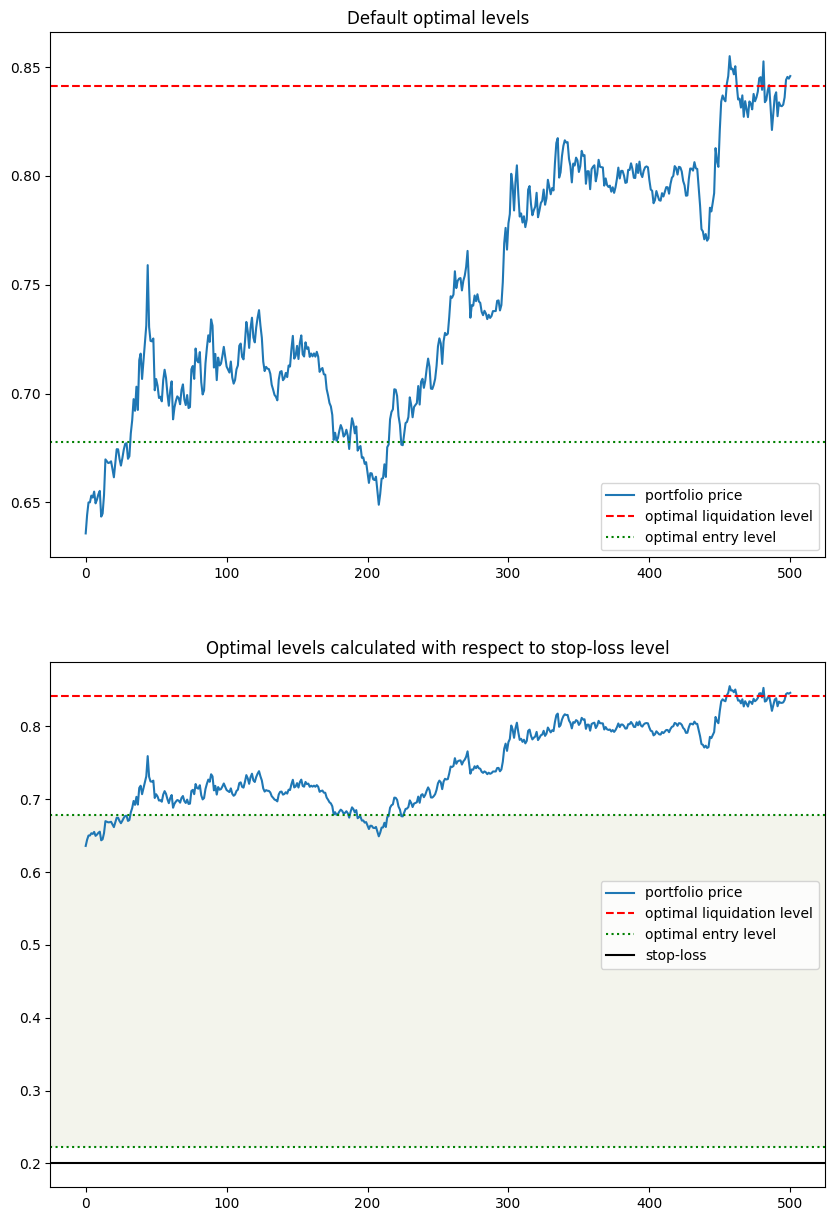

In [ ]:
# show result
fig = example.plot_levels(data=data_train_dataframe, stop_loss=True)
fig.set_figheight(15)
fig.set_figwidth(10)

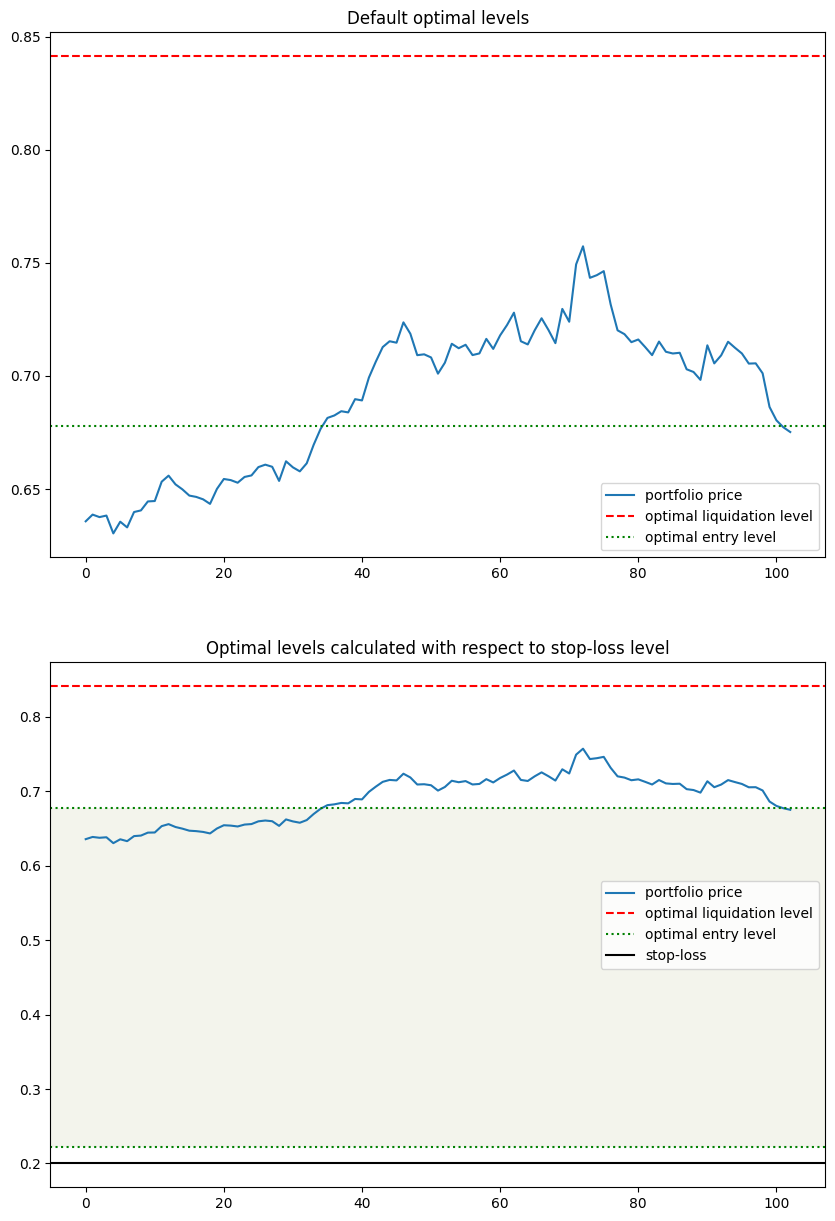

In [ ]:
# show retrain
fig = example.plot_levels(data=data_test_and_retrain, stop_loss=True)
fig.set_figheight(15)
fig.set_figwidth(10)

In [ ]:
# retrain
example.fit_to_assets(data=np.array(data_test_and_retrain))
example.check_fit()

,Theta,Mu,Sigma,Max log-likelihood
empirical,0.749335,6.976759,0.098424,3.678030
simulated,0.755084,8173.349461,0.003162,9.448027


In [ ]:
# show retrained
example.L = 0.2
example.description()

training period                         [None, None]
long-term mean                              0.749335
speed of reversion                          6.976759
volatility                                  0.098424
fitting error                              -0.018116
discount rates                          [0.05, 0.05]
transaction costs                       [0.02, 0.02]
stop-loss level                                  0.2
beta                                        0.323909
optimal entry level                         0.676363
optimal liquidation level                   0.782339
optimal entry interval [sl]       [0.20768, 0.67636]
optimal liquidation level [sl]              0.782339
dtype: object

In [ ]:
# previously we use the use threshold at which you decide that the process has deviated far enough from the mean
# now use z-score
volatility = 0.098423
# Calculate deviation from mean in terms of volatility (Z-score)
long_term_mean = example.theta  # The long-term mean

# Optimal entry level deviation as a Z-score
optimal_entry_level = example.optimal_entry_level()
optimal_liquidation_level = example.optimal_liquidation_level()

optimal_entry_z = (optimal_entry_level - long_term_mean) / volatility
optimal_liquidation_z = (optimal_liquidation_level - long_term_mean) / volatility

print(f"Optimal Entry Level: {optimal_entry_z:.2f} standard deviations from the mean")
print(f"Optimal Liquidation Level: {optimal_liquidation_z:.2f} standard deviations from the mean")

Optimal Entry Level: -0.74 standard deviations from the mean
Optimal Liquidation Level: 0.34 standard deviations from the mean


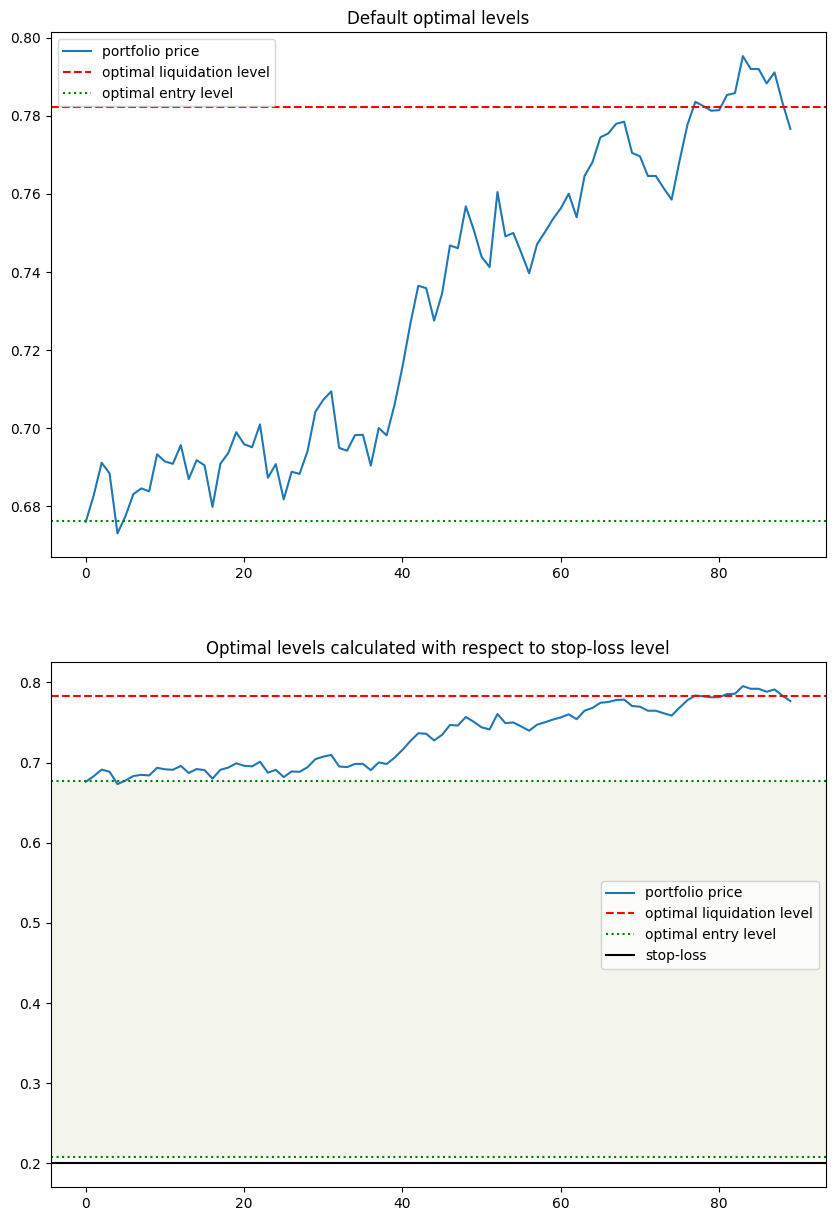

In [ ]:
fig = example.plot_levels(data=data_test_the_retrained, stop_loss=True)
fig.set_figheight(15)
fig.set_figwidth(10)

In [ ]:
example.half_life()

0.09935089058169284

In [ ]:
import statsmodels.api as sm
# Create the spread: Spread = GLD - SIL
data_train_dataframe['Spread'] = data_train_dataframe["GLD"] - data_train_dataframe["SIL"]

# Perform regression on the spread (mean reversion in pairs trading is typically on the spread)
X_t_plus_1 = data_train_dataframe['Spread'].iloc[1:]
X_t = data_train_dataframe['Spread'].shift(1).iloc[1:]

# OLS regression (X_t+1 = beta1 * X_t + beta0)
X_t = sm.add_constant(X_t)
model = sm.OLS(X_t_plus_1, X_t).fit()

beta_1 = model.params[1]
beta_0 = model.params[0]

# Step 4: Calculate mu and theta from beta_1 and beta_0
delta_t = 1  # Assuming daily data, so delta_t = 1
mu = (1 - beta_1) / delta_t  # mu = (1 - beta1) / delta_t
theta = beta_0 / (mu * delta_t)  # theta = beta0 / (mu * delta_t)

print(f"mu = {mu}")
print(f"theta = {theta}")

mu = 0.007427187576881544
theta = 154.56347480686512
